In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
imagergb = cv2.imread('images/nb.jpg')
img = cv2.cvtColor(imagergb,cv2.COLOR_BGR2RGB)
print(img.shape)

(4000, 3000, 3)


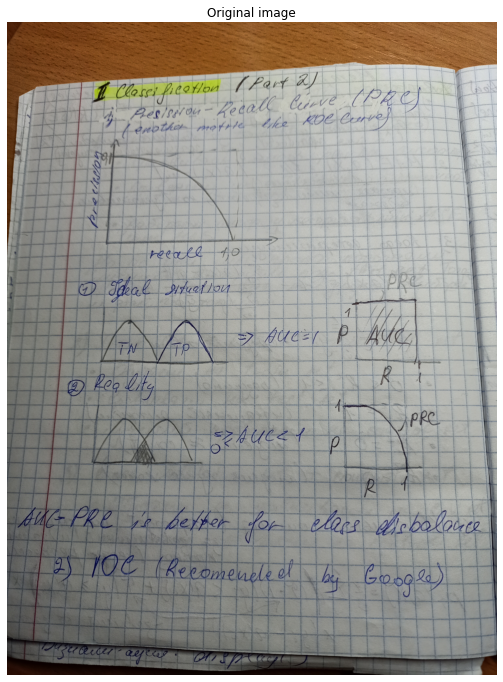

In [20]:
plt.figure(figsize=(9,12))
plt.clf()
plt.axis("off")
plt.title("Original image")
plt.imshow(img)

In [21]:
gray = cv2.cvtColor(imagergb,cv2.COLOR_BGR2GRAY)

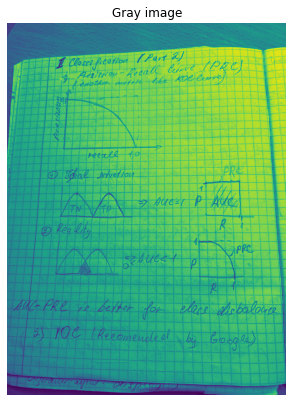

In [22]:
plt.figure(figsize=(5,10))
plt.axis("off")
plt.title("Gray image")
plt.imshow(gray)

In [23]:
low_sigma = cv2.GaussianBlur(gray,(1,1),0)
high_sigma = cv2.GaussianBlur(gray,(11,11),0)

# Calculate the DoG by subtracting
dog = low_sigma - high_sigma

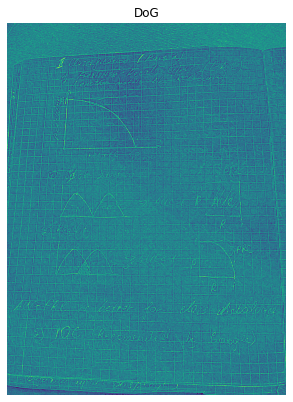

In [24]:
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("DoG")
plt.imshow(dog)

In [25]:
edges = cv2.Canny(gray, 50, 80, apertureSize=3, L2gradient=True)

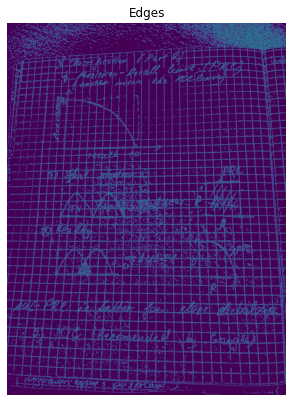

In [26]:
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Edges")
plt.imshow(edges)

In [27]:
lines = cv2.HoughLines(edges, 1, np.pi/360, 650,)

horizontal_lines = []
vertical_lines = []
img_copy = img.copy()

for i, _ in enumerate(lines):
    for rho, theta in lines[i]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 4000*(-b))
        y1 = int(y0 + 4000*(a))
        x2 = int(x0 - 4000*(-b))
        y2 = int(y0 - 4000*(a))
        if abs(x1-x2) > 1000:
            cv2.line(img_copy,(x1,y1),(x2,y2),(255,0,0),2)
            horizontal_lines.append(((x1, y1, 1), (x2, y2, 1)))
        else:
            cv2.line(img_copy,(x1,y1),(x2,y2),(0,255,0),2)
            vertical_lines.append(((x1, y1, 1), (x2, y2, 1)))

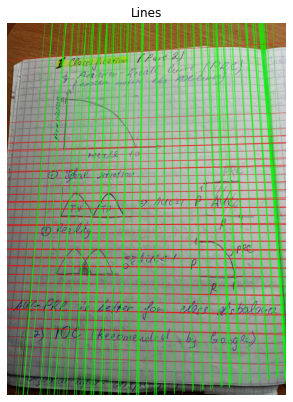

In [28]:
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy)

((-3968, 637, 1), (4016, 149, 1))
((93, 4019, 1), (721, -3955, 1))
((-4122, 3432, 1), (3872, 3711, 1))
((2714, -4097, 1), (2993, 3897, 1))


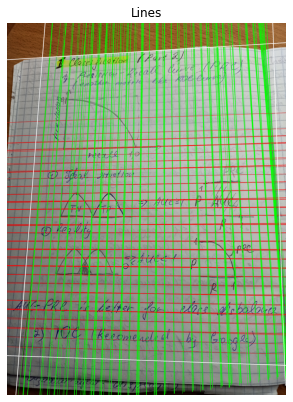

In [29]:
left = vertical_lines[np.array(vertical_lines)[:,0, 0].argmin()]
right = vertical_lines[np.array(vertical_lines)[:,0, 0].argmax()]
top = horizontal_lines[np.array(horizontal_lines)[:,0, 1].argmin()]
bottom = horizontal_lines[np.array(horizontal_lines)[:,0, 1].argmax()]

for line in [top, left, bottom, right]:
    print(line)
    cv2.line(img_copy,line[0][:2], line[1][:2],(255,255,255), 5)
    
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy)

In [30]:
line_coef_list = list(map(lambda x: np.cross(x[0], x[1]), [top, left, bottom, right]))

cross_points = []
for i, coefs in enumerate(line_coef_list):
    try:
        cross_points.append((np.cross(coefs, line_coef_list[i+1])/np.cross(coefs, line_coef_list[i+1])[2])[:2])
    except IndexError:
        cross_points.append((np.cross(coefs, line_coef_list[0])/np.cross(coefs, line_coef_list[0])[2])[:2])
        
cross_points

[array([380.28415918, 371.22311251]),
 array([ 127.54911513, 3580.31426109]),
 array([2985.42845551, 3680.05761059]),
 array([2864.64650406,  219.37330987])]

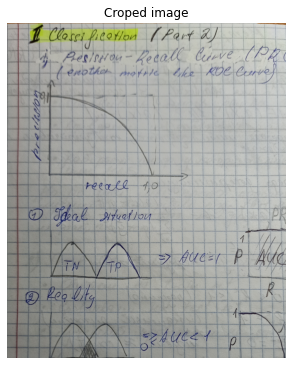

In [31]:
srcpts = np.float32([cross_points]) 
shape = (3000, 4000)
destpts = np.float32([[0, 0],  [0, shape[1]], shape, [shape[0], 0]]) 
resmatrix = cv2.getPerspectiveTransform(srcpts, destpts)
resultimage = cv2.warpPerspective(img, resmatrix, (2500, 3000))
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Croped image")
plt.imshow(resultimage)

In [32]:
def find_edges(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    low_sigma = cv2.GaussianBlur(gray,(1,1),0)
    high_sigma = cv2.GaussianBlur(gray,(11,11),0)
    # Calculate the DoG by subtracting
    dog = low_sigma - high_sigma
    #find image edges
    return cv2.Canny(gray, 50, 80, apertureSize=3, L2gradient=True)



def find_lines(edges):
    max_axis = max(edges.shape)
    min_axis = min(edges.shape)
    horizontal_lines = []
    vertical_lines = []  
    
    lines = cv2.HoughLines(edges, 1, np.pi/360, int(min_axis/3),)
    for i, _ in enumerate(lines):
        for rho, theta in lines[i]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + max_axis*(-b))
            y1 = int(y0 + max_axis*(a))
            x2 = int(x0 - max_axis*(-b))
            y2 = int(y0 - max_axis*(a))
            if abs(x1-x2) > 1000:
                horizontal_lines.append(((x1, y1, 1), (x2, y2, 1)))
            else:
                vertical_lines.append(((x1, y1, 1), (x2, y2, 1)))
    return horizontal_lines, horizontal_lines



def find_corner_points(*boundaries):
    corner_points = []
    line_coef_list = list(map(lambda x: np.cross(x[0], x[1]), boundaries))
    for i, coefs in enumerate(line_coef_list):
        try:
            corner_points.append((np.cross(coefs, line_coef_list[i+1])/
                                  np.cross(coefs, line_coef_list[i+1])[2])[:2])
        except IndexError:
            corner_points.append((np.cross(coefs, line_coef_list[0])/
                                  np.cross(coefs, line_coef_list[0])[2])[:2])
    return corner_points 



def find_optimal_new_shape():
    pass



def crop_image(image, new_shape, verbose=True):
    edges = find_edges(image)
    horizontal_lines, vertical_lines = find_lines(edges)
    
    left = vertical_lines[np.array(vertical_lines)[:,0, 0].argmin()]
    right = vertical_lines[np.array(vertical_lines)[:,0, 0].argmax()]
    top = horizontal_lines[np.array(horizontal_lines)[:,0, 1].argmin()]
    bottom = horizontal_lines[np.array(horizontal_lines)[:,0, 1].argmax()]
    
    corners = find_corner_points(top, left, bottom, right)
    
    srcpts = np.float32([corners]) 
    destpts = np.float32([[0, 0],  [0, new_shape[1]], new_shape, [new_shape[0], 0]]) 
    resmatrix = cv2.getPerspectiveTransform(srcpts, destpts)
    result_image = cv2.warpPerspective(image, resmatrix, new_shape)
    if verbose:
        plt.figure(figsize=(5,10))
        plt.axis("off")
        plt.title("Croped image")
        plt.imshow(resultimage)
    return result_image

<ipython-input-32-774db8f06bb6>:42: RuntimeWarning: invalid value encountered in true_divide
  corner_points.append((np.cross(coefs, line_coef_list[i+1])/
<ipython-input-32-774db8f06bb6>:45: RuntimeWarning: invalid value encountered in true_divide
  corner_points.append((np.cross(coefs, line_coef_list[0])/


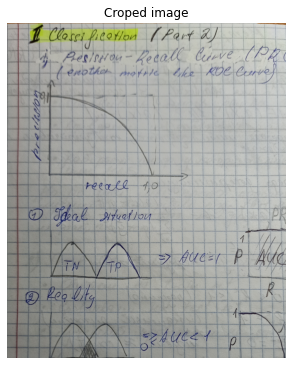

In [33]:
croped = crop_image(img, (3000,4000))